# Perturbation for Lotka-Voltera model 

In [2]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy

from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool


In [3]:
def generate_model_params(num_native, A_mean, A_std_dev, u_mean, u_std_dev):
    a = np.random.rand(num_native, num_native)
    # Make the matrix symmetric, and set diagonal to 1
    A = A_mean + A_std_dev * (np.tril(a) + np.tril(a, -1).T)
    np.fill_diagonal(A, 1.0) #need to expand this in the future for assymetric model
    
    u = np.random.normal(u_mean, u_std_dev, num_native)
    return A, u
    
def lotka_volterra(t, state, A, u, migration):
    return state * (u - A @ state)+ migration
    
def LV_simulator(initial_state, A, u, migration, max_time=500000, steady_state_threshold=1e-12):
    ode_function = lambda t, state: lotka_volterra(t, state, A, u, migration)

    def check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = ode_function(t, y)
        return np.max(np.abs(derivatives)) > steady_state_threshold

    # Integrate until steady state or max_time is reached
    check_steady_state.terminal = True
    sol = solve_ivp(ode_function, t_span=(0, max_time), y0=initial_state.copy(), method='LSODA', atol=1e-12, rtol=1e-12, events=[check_steady_state])
    
    # Check if the integration reached the maximum time
    time_limit_reached = sol.t[-1] == max_time
    if time_limit_reached: print('max integration time reached')
    
    return sol

def invasion(A, A_II,A_IS,A_SI, u, u_I):
    num_native = len(u)
    num_invaders = len(u_I)
    A_new = np.zeros((num_native + num_invaders, num_native + num_invaders))
    A_new[:num_native, :num_native] = A
    A_new[num_native:, :num_native] = A_IS
    A_new[:num_native, num_native:] = A_SI
    A_new[num_native:, num_native:] = A_II
    u_new = np.concatenate((u, u_I))
    return A_new, u_new

def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array

def mutation(mean_value, parent_zero_mean, random_zero_mean, mutation_correlation):
    # Apply mutation, which preserve mean and variance of parent
    return mean_value + mutation_correlation * parent_zero_mean+ np.sqrt(1-mutation_correlation**2) * (random_zero_mean)


def sample_invaders(num_invaders, num_native, A_mean, A_std_dev, u_mean, u_std_dev, parent_correlation, A_SS, u_S):
    
    num_parents = A_SS.shape[1]

    # Choose parent indices for each invader
    parent_indices = np.random.choice(num_parents, num_invaders)
    
    # Sample A_SI and A_IS with mutation
    parent_A_SI = A_SS[:, parent_indices] - A_mean
    random_A_SI = np.random.normal(0, A_std_dev, (num_native, num_invaders))
    A_SI = mutation(A_mean, parent_A_SI, random_A_SI, parent_correlation)

    parent_A_IS = A_SS[parent_indices, :] - A_mean
    random_A_IS = np.random.normal(0, A_std_dev, (num_invaders, num_native))
    A_IS = mutation(A_mean, parent_A_IS, random_A_IS, parent_correlation)
    
    # Sample u_I with mutation
    parent_u_I = u_S[parent_indices] - u_mean
    random_u_I = np.random.normal(0, u_std_dev, num_invaders)
    u_I = mutation(u_mean, parent_u_I, random_u_I, parent_correlation)
    
    # Sample A_II 
    A_II = np.array([[1]]) #+ np.random.normal(A_mean, A_std_dev, (num_invaders, num_invaders))
    
    return A_SI, A_IS, A_II, u_I





Plot all different stablt fixed point of the ecological dynamics

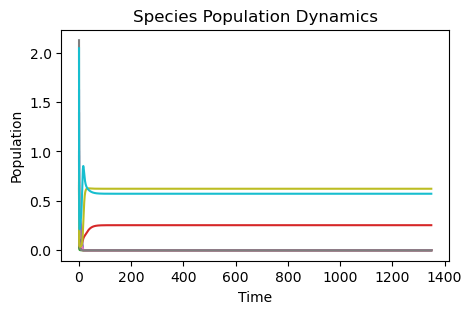

In [11]:
# Parameters

num_pool = 10

A_mean = 1/num_pool
A_std_dev = 10/np.sqrt(num_pool)
u_mean = 1
u_std_dev = 0.1

migration=1e-8
Xthreshold=1e-3

A, u = generate_model_params(num_pool, A_mean, A_std_dev, u_mean, u_std_dev)
# Run multiple simulations to detect multistability
num_trials = 40
final_states = []
initial_state = np.random.uniform(0.5, 2.5, num_pool)
sol = LV_simulator(initial_state, A, u, migration, steady_state_threshold=1e-16)
plt.figure(figsize=(5,3))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Species Population Dynamics')

for _ in range(num_trials):
    initial_state = np.random.uniform(0.5, 2.5, num_pool)
    sol = LV_simulator(initial_state, A, u, migration, steady_state_threshold=1e-16)
    current_final_state = sol.y.T[-1]
    
    # Compare with all stored final states
    if final_states:
        is_different = False
        for stored_state in final_states:
            rel_diff = np.abs(current_final_state - stored_state) / np.abs(stored_state)
            if np.any(rel_diff < 0.2):  # 20% threshold
                is_different = False
                break
            else:
                is_different = True
        
        if is_different:
            print("Multistability detected: Current final state differs from a previous state by >20%")
            plt.figure(figsize=(5,3))
            plt.plot(sol.t, sol.y.T)
            plt.xlabel('Time')
            plt.ylabel('Population')
            plt.title('Alternative Species Population Dynamics')
            final_states.append(current_final_state)
    else:
        final_states.append(current_final_state)

def check_multistability(A, u, migration=1e-8, num_trials=40, threshold=0.2, steady_state_threshold=1e-16):
    """
    Check if the system exhibits multistability by running multiple simulations 
    with different initial conditions.
    
    Parameters:
    -----------
    A : ndarray
        Interaction matrix
    u : ndarray 
        Growth rates
    migration : float
        Migration rate
    num_trials : int
        Number of trials with different initial conditions
    threshold : float
        Relative difference threshold to consider states different (default 0.1 = 10%)
    steady_state_threshold : float
        Threshold for steady state detection
        
    Returns:
    --------
    list
        List of different final states found
    bool
        True if multistability detected, False otherwise
    """
    num_pool = len(u)
    final_states = []
    
    for _ in range(num_trials):
        # Random initial condition
        initial_state = np.random.uniform(0.5, 2.5, num_pool)
        
        # Run simulation
        sol = LV_simulator(initial_state, A, u, migration, steady_state_threshold=steady_state_threshold)
        current_final_state = sol.y.T[-1]
        
        # Compare with stored states
        if final_states:
            is_different = False
            for stored_state in final_states:
                rel_diff = np.abs(current_final_state - stored_state) / np.abs(stored_state)
                if np.any(rel_diff < threshold):
                    is_different = False
                    break
                else:
                    is_different = True
            
            if is_different:
                final_states.append(current_final_state)
        else:
            final_states.append(current_final_state)
            
    return final_states, len(final_states) > 1


In [10]:
# # Parameters
# num_pool = 10
# A_mean = 1/num_pool
# u_mean = 1
# u_std_dev = 0.1

# # Range of A_std_dev values to test
# A_std_devs = np.linspace(0.1, 10, 10)/np.sqrt(num_pool)
# num_trials = 500  # Number of trials for each A_std_dev

# # Store probability of multistability for each A_std_dev
# multistability_probs = []

# for A_std in A_std_devs:
#     multistable_count = 0
    
#     for _ in range(num_trials):
#         A, u = generate_model_params(num_pool, A_mean, A_std, u_mean, u_std_dev)
#         final_states = check_multistability(A, u,steady_state_threshold=1e-13)
#         if len(final_states) > 1:  # If more than one stable state found
#             multistable_count += 1
    
#     prob = multistable_count / num_trials
#     multistability_probs.append(prob)

# # Plot results
# plt.figure(figsize=(4, 3))
# plt.plot(A_std_devs * np.sqrt(num_pool), multistability_probs, '-o')
# plt.xlabel('Standard Deviation of Interaction Matrix (σ√N)')
# plt.ylabel('Probability of Multistability')
# plt.grid(True)

# # Plot results
# plt.figure(figsize=(4, 3))
# plt.plot(A_std_devs * np.sqrt(num_pool), multistability_probs, '-o')
# plt.xlabel('Standard Deviation of Interaction Matrix (σ√N)')
# plt.ylabel('Probability of Multistability')
# plt.grid(True)
# plt.savefig('multistability_vs_interaction_strength.pdf', bbox_inches='tight')

In [7]:
# Parameters
num_systems = 640
num_invaders = 1  # Number of invaders
num_knock_offs = 0 # Number of knock-offs
num_pool = 10
parent_correlation=0 #correlation coefficcient with parent
A_mean = 1/num_pool
A_std_dev = 10/np.sqrt(num_pool)

u_mean = 1
u_std_dev = 0.1
deltau_mean = 0
deltau_std_dev = 0
migration=0
Xthreshold=1e-2

ODE_steady_states = []
old_ODE_steady_states = []
perturbation_predictions = []
info_predicted_Xs = []
sim_Xbools=[]
predicted_Xbools=[]
list_invasion_fitness=[]
list_screened_invader_impact=[]
list_M_inv=[]

systems_found = 0
while systems_found < num_systems:
    # Generate model parameters for each system
    A, u = generate_model_params(num_pool, A_mean, A_std_dev, u_mean, u_std_dev)
    
    # Check for multistability more efficiently by stopping once we find a different state
    num_initial_states = 10
    initial_states = [np.random.uniform(0.1, 1.5, num_pool) for _ in range(num_initial_states)]
    
    # Get first steady state
    sol = LV_simulator(initial_states[0], A, u, migration)
    first_state = sol.y.T[-1].copy()
    first_state[first_state < Xthreshold] = 0
    
    # Check other initial conditions until we find a different state
    found_different = False
    for init_state in initial_states[1:]:
        sol = LV_simulator(init_state, A, u, migration) 
        final_state = sol.y.T[-1].copy()
        final_state[final_state < Xthreshold] = 0
        
        if not np.allclose(first_state, final_state):
            found_different = True
            break
            
    if not found_different:
        continue # Skip this system if no multistability found
    
    systems_found += 1
    initial_state = np.random.uniform(0.5,1.5, num_pool)
    
    # Simulate the initial system
    sol = LV_simulator(initial_state, A, u, migration)
    oldX = sol.y.T[-1]
    
    # Take the initial surviving system 
    Sbool=[(x > Xthreshold) for x in oldX] 
    num_native=sum(Sbool)
    As, us, oldXs = A[Sbool,::][::,Sbool], u[Sbool], oldX[Sbool]
    old_ODE_steady_states.append(oldXs)
    
    # Sample invaders with positive invasion fitness
    while True:
        A_SI, A_IS, A_II, u_I = sample_invaders(num_invaders, num_native, A_mean, A_std_dev/10, u_mean, u_std_dev, parent_correlation, As, us)
        if u_I-A_IS@oldXs>0:
            break

    # Set knock off species from the system
    knock_off=np.array([False]*len(As))
    knock_off=set_random_true(knock_off, num_knock_offs)
    
    #Sample environmental perturbation
    delta_u=np.random.normal(deltau_mean, deltau_std_dev, num_native)
    
    # Add invaders 
    A_new, u_new = invasion(As, A_II, A_IS, A_SI, us+delta_u, u_I)
    new_initial_state = np.concatenate((oldXs,[1e-1]))

    # Simulate new system
    new_sol = LV_simulator(new_initial_state, A_new, u_new, migration)
    newX = new_sol.y.T[-1]
    simulator_Sbool = [(x > Xthreshold) for x in newX]
        
    ODE_steady_states.append(newX)
    
    # Compute perturbation prediction given what survives
    num_original = len(As)
    
    info_predicted_X, screened_invader_impact, M_inv, invasion_fitness = prediction_given_Sbool(As, oldXs, us, delta_u, A_II, A_IS, A_SI, u_I, simulator_Sbool[:num_original], simulator_Sbool[num_original:])
    info_predicted_Xs.append(info_predicted_X)
    list_invasion_fitness.append(invasion_fitness[0])
    list_screened_invader_impact.append(screened_invader_impact)
    if M_inv[0,0] > 0:
        list_M_inv.append( [0,0])
    else:
        print('M_inv',M_inv)
        list_M_inv.append(0)
    
    # Compute perturbation prediction from iterative approach
    predicted_XList = general_perturbation_prediction(As, oldXs, us, delta_u, knock_off, A_II, A_IS, A_SI, u_I, num_iters=50, momentum=0.1,survival_threshold=Xthreshold)
    perturbation_prediction = np.array(predicted_XList)[-1]
    prediction_Sbool = [(x > Xthreshold) for x in perturbation_prediction]
    perturbation_predictions.append(perturbation_prediction)

    # Save prediction and simulation Bools
    sim_Xbools.append(simulator_Sbool)
    predicted_Xbools.append(prediction_Sbool)

In [8]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()

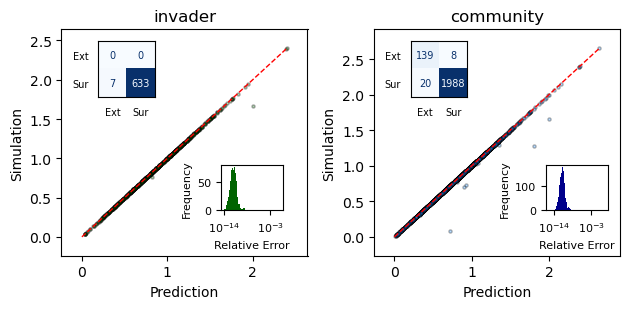

In [9]:
# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2, figure_width * 1))

# Filter data for positive predictions
sim_Xbools_concatenated = np.concatenate(sim_Xbools)
prediction_Xbool_concatenated = np.concatenate(predicted_Xbools)
intersection = [a and b for a, b in zip(sim_Xbools_concatenated, prediction_Xbool_concatenated)]
positive_indices = np.array(intersection) > 0

filtered_simulationX_after = np.concatenate(ODE_steady_states)[positive_indices]
filtered_predictionXs = np.concatenate(perturbation_predictions)[positive_indices]

# Filter N_0 data for positive predictions
simulation_invader = np.array([x[-1] for x in ODE_steady_states])
prediction_invader = np.array([x[-1] for x in perturbation_predictions])
threshold_invader = 1e-8 # Define a threshold value if needed
sim_invader_bool = simulation_invader > threshold_invader
pred_invader_bool = prediction_invader > threshold_invader
intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0

filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]

# Scatter plot for N_0 (reversed axes)
maxX0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxX0 * 0.1, 1.1 * maxX0)
ax[0].set_ylim(-maxX0 * 0.1, 1.1 * maxX0)
ax[0].set_title(f'invader')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool.astype(int), pred_invader_bool.astype(int), ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist2 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist2.set_xticks([-14, -3])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-14}$', '$10^{-3}$'])  # Replace with your desired tick labels


# Scatter plot for N (reversed axes)
maxX = np.max(np.concatenate(ODE_steady_states))
scatter_n = ax[1].scatter(filtered_predictionXs, filtered_simulationX_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxX * 0.1, 1.1 * maxX)
ax[1].set_ylim(-maxX * 0.1, 1.1 * maxX)
ax[1].set_title(f'community')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Xbools_concatenated, prediction_Xbool_concatenated, ax=inset_ax_n)

# Histogram for relative error of N
ax_hist0 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulationX_after - filtered_predictionXs) / filtered_simulationX_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-14, -3])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-14}$', '$10^{-3}$'])  # Replace with your desired tick labels


plt.tight_layout()
fig.savefig("multistability_single_LV_work.pdf", format="pdf")

plt.show()
